In [494]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy_financial as npf
import json

In [495]:
import FIRE as fire
import imp
imp.reload(fire)

<module 'FIRE' from '/media/erik/Samsung_SSD/1_Data/11_Finances/1192_Planning/230806_FIRE/fire-calculator/FIRE.py'>

# Notes

All values are expressed in todays (nominal) €'s. This makes estimation of prices easier as they can be judged from today.
Thus, also things like the earings/monthly investment growth shall not consider the effects of inflation.

It is currently assumed that initial assets and monthly investment will retain the same portfolio structure. This means, no rebalancing of the portfolio takes place to e.g. a certain percentage of low-risk bond investments.

# Setup

In [505]:
# Boundary conditions / external effects
all_conditions = fire.FIREExternalConditionsArray('../External.json')
print(f"Available conditions: {all_conditions.keys()}")
conditions = all_conditions.select("SCENARIO_AVERAGE_INFLATION_AND_CAPITAL_TAX")

# Income/assets + Investments
all_investments = fire.FIREInvestmentArray('../Investments.json')
investments = all_investments.select("SCENARIO_1")
print(f"Available investments: {all_investments.keys()}")

# Target
all_targets = fire.FIRETargetArray('../Targets.json')
target = all_targets.select("SCENARIO_LIVABLE_AGGRESSIVE")
print(f"Available targets: {all_targets.keys()}")

# Simulation
simulation = fire.FIRESimulation(investments=investments, target=target, conditions=conditions)

Available conditions: dict_keys(['SCENARIO_AVERAGE_INFLATION_AND_CAPITAL_TAX'])
Available investments: dict_keys(['SCENARIO_1'])
Available targets: dict_keys(['SCENARIO_RICH_CONSERVATIVE', 'SCENARIO_RICH_AGGRESSIVE', 'SCENARIO_LIVABLE_CONSERVATIVE', 'SCENARIO_LIVABLE_AGGRESSIVE', 'SCENARIO_INCOME_AGGRESSIVE'])


# Investment analysis

/home/erik/Software/miniconda3/envs/dev/lib/python3.11/site-packages/numpy_financial/_financial.py:130: RuntimeWarning: divide by zero encountered in divide
  (1 + rate*when)*(temp - 1)/rate)
/home/erik/Software/miniconda3/envs/dev/lib/python3.11/site-packages/numpy_financial/_financial.py:130: RuntimeWarning: invalid value encountered in divide
  (1 + rate*when)*(temp - 1)/rate)


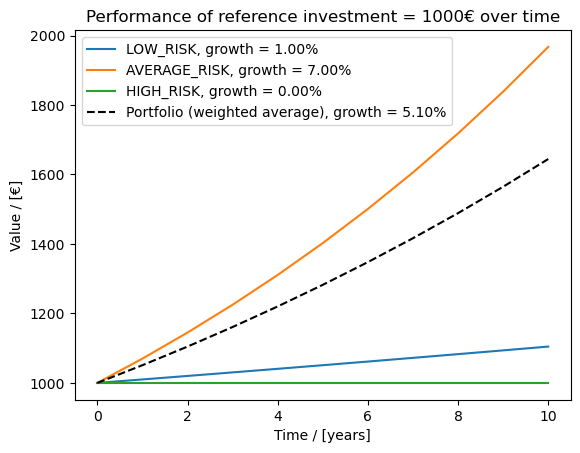

In [506]:
investments.plot_portfolio_performance("FIX")

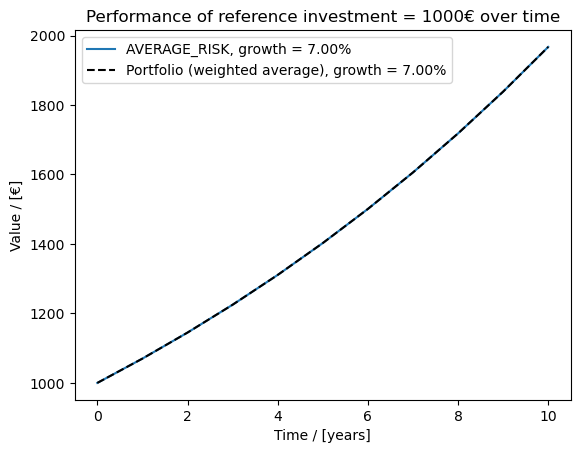

In [507]:
investments.plot_portfolio_performance("VAR")

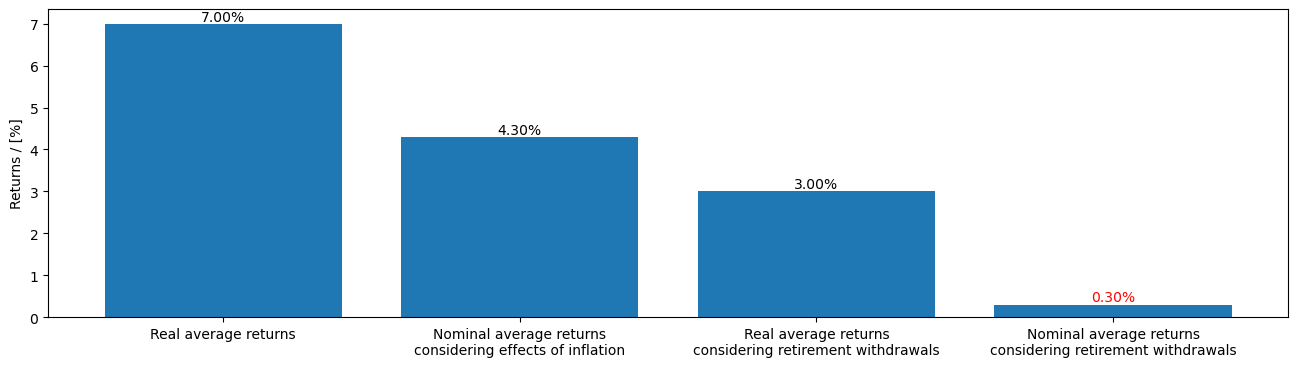

In [508]:
plt.figure(figsize=(16,4))
simulation.plot_growth_rates()

# Target analysis

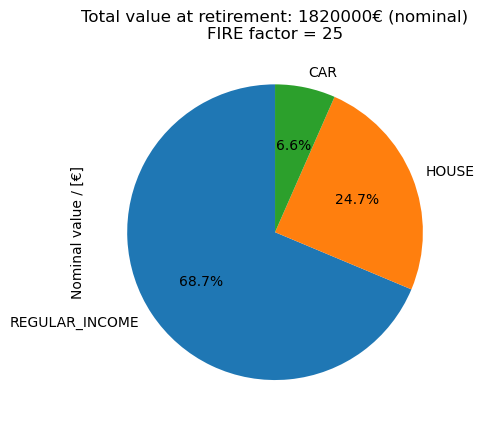

In [509]:
target.plot_pie_value()

# FIRE analysis

In [510]:
sim_res = simulation.perform()

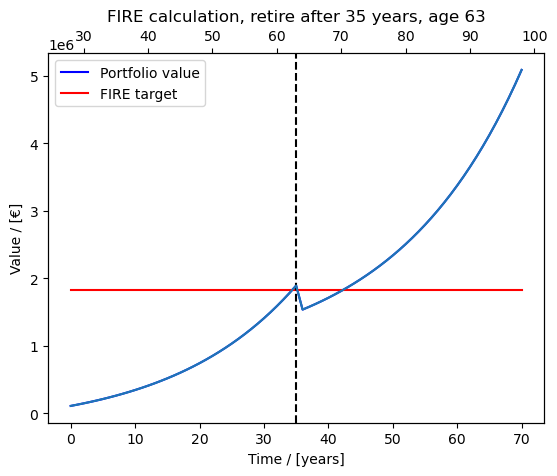

In [511]:
simulation.plot_value_over_time()

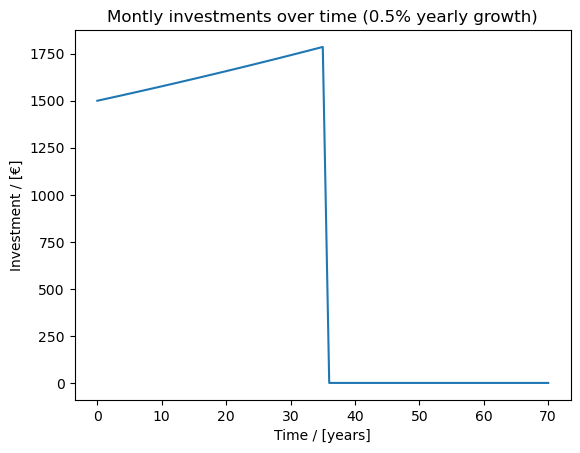

In [512]:
simulation.plot_investments_over_time()

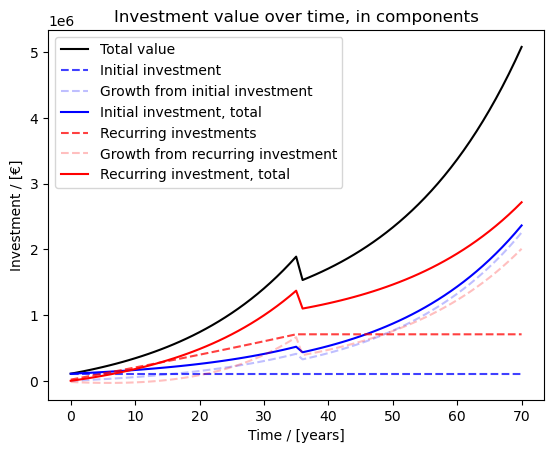

In [513]:
simulation.plot_value_components_over_time()